In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True
from imageio import imread
from datetime import datetime
import shutil
import skimage
import cv2
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

from __future__ import print_function
import keras
from keras import applications
from keras.models import Sequential
from keras.layers import Conv2D,Conv2DTranspose,MaxPooling2D
from keras import backend as K
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.initializers import RandomNormal
from keras.initializers import he_normal
from keras.applications import vgg16 as vgg
from keras.applications.resnet50 import ResNet50
from keras.optimizers import adam
from keras import optimizers
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import warnings
warnings.filterwarnings("ignore")

C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
pristine_path = "C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training/dataset-dist/phase-01/training/pristine/pristine_128/"
fake_path  = "C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training/dataset-dist/phase-01/training/fake/fake_128/"
mask_path = "C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training/dataset-dist/phase-01/training/maskfiles/mask_128/"

In [3]:
fake_file_names = os.listdir(fake_path)
mask_file_names = os.listdir(mask_path)

In [4]:
len(mask_file_names),len(fake_file_names)

(450, 450)

In [5]:
mask_images=[]
for file in mask_file_names:
    try:
        img=imread(mask_path+file)
    except FileNotFoundError:
        print("No file found")
    
    mask_images.append(img)


# Convert grayscale images to binary
binaries=[]

for grayscale in mask_images:
    blur = cv2.GaussianBlur(grayscale,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binaries.append(th)


    
fake_images=[]
for file in fake_file_names:
    try:
        img=imread(fake_path+file)
    except FileNotFoundError:
        print("No file found")
    
    fake_images.append(img)

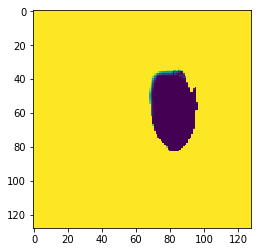

In [6]:
plt.imshow(mask_images[0])

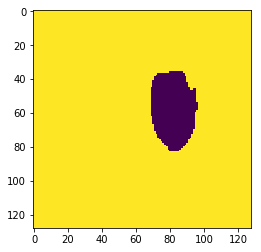

In [7]:
plt.imshow(binaries[0])

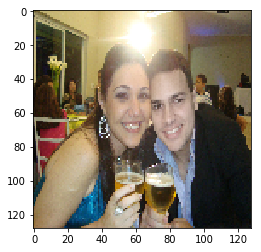

In [8]:
plt.imshow(fake_images[0])

In [9]:
mask_images_arr = np.array(binaries)
fake_images_arr = np.array(fake_images)
type(mask_images_arr),type(fake_images_arr)

(numpy.ndarray, numpy.ndarray)

In [10]:
fake_images_arr.shape,mask_images_arr.shape

((450, 128, 128, 3), (450, 128, 128))

In [11]:
if K.image_data_format() == 'channels_first':
    fake_images_arr = fake_images_arr.reshape(fake_images_arr.shape[0], 3, 128, 128)
    mask_images_arr = mask_images_arr.reshape(mask_images_arr.shape[0], 1, 128, 128)
    input_shape = (1, 128, 128)
else:
    fake_images_arr = fake_images_arr.reshape(fake_images_arr.shape[0], 128, 128, 3)
    mask_images_arr = mask_images_arr.reshape(mask_images_arr.shape[0], 128, 128, 1)
    input_shape = (128, 128, 1)

In [12]:
X = fake_images_arr.astype('float32')
y = mask_images_arr.astype('float32')

# Normalizing the data
X /= 255
y /= 255

print('X shape:', X.shape)
print('y shape:', y.shape)
print(X.shape[0], 'train samples')
print(y.shape[0], 'labels')

X shape: (450, 128, 128, 3)
y shape: (450, 128, 128, 1)
450 train samples
450 labels


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
# https://stackoverflow.com/questions/51844995/how-do-i-implement-a-loss-function-intersection-over-union-for-a-sequential-mo
def iou(true, pred):

    intersection = true * pred

    notTrue = 1 - true
    union = true + (notTrue * pred)

    return K.sum(intersection)/K.sum(union)

def iou_metric(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [22]:
del model

In [23]:
input_img = Input((128, 128, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.25, batchnorm=False)
model.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[iou])

In [24]:

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 128, 128, 16) 0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 16)   0           activation_20[0][0]              
__________________________________________________________________________________________________
dropout_9 

In [25]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-seg_iou_3.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [26]:
results = model.fit(X_train, y_train, batch_size=64, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test))

Train on 360 samples, validate on 90 samples
Epoch 1/50
360/360 [==============================] - 70s 194ms/step - loss: 0.4167 - iou: 0.7267 - val_loss: 0.3098 - val_iou: 0.7866

Epoch 00001: val_loss improved from inf to 0.30981, saving model to model-seg_iou_3.h5
Epoch 2/50
360/360 [==============================] - 69s 192ms/step - loss: 0.3024 - iou: 0.8409 - val_loss: 0.2906 - val_iou: 0.8176

Epoch 00002: val_loss improved from 0.30981 to 0.29055, saving model to model-seg_iou_3.h5
Epoch 3/50
360/360 [==============================] - 69s 193ms/step - loss: 0.2893 - iou: 0.8531 - val_loss: 0.2947 - val_iou: 0.8008

Epoch 00003: val_loss did not improve from 0.29055
Epoch 4/50
360/360 [==============================] - 69s 193ms/step - loss: 0.2820 - iou: 0.8538 - val_loss: 0.3088 - val_iou: 0.7772

Epoch 00004: val_loss did not improve from 0.29055
Epoch 5/50
360/360 [==============================] - 70s 193ms/step - loss: 0.2776 - iou: 0.8538 - val_loss: 0.2914 - val_iou: 0.7

360/360 [==============================] - 70s 194ms/step - loss: 0.2448 - iou: 0.8729 - val_loss: 0.2410 - val_iou: 0.8547

Epoch 00041: val_loss did not improve from 0.24015
Epoch 42/50
360/360 [==============================] - 70s 193ms/step - loss: 0.2448 - iou: 0.8728 - val_loss: 0.2415 - val_iou: 0.8531

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00042: val_loss did not improve from 0.24015
Epoch 43/50
360/360 [==============================] - 70s 194ms/step - loss: 0.2448 - iou: 0.8722 - val_loss: 0.2415 - val_iou: 0.8531

Epoch 00043: val_loss did not improve from 0.24015
Epoch 44/50
360/360 [==============================] - 71s 196ms/step - loss: 0.2445 - iou: 0.8724 - val_loss: 0.2415 - val_iou: 0.8531

Epoch 00044: val_loss did not improve from 0.24015
Epoch 45/50
360/360 [==============================] - 70s 193ms/step - loss: 0.2440 - iou: 0.8724 - val_loss: 0.2414 - val_iou: 0.8532

Epoch 00045: val_loss did not improve fro

In [27]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test iou:', score[1])

Test loss: 0.24130763543976677
Test iou: 0.8532891260253058


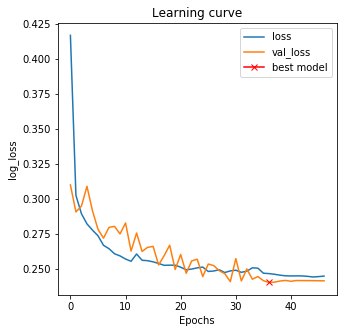

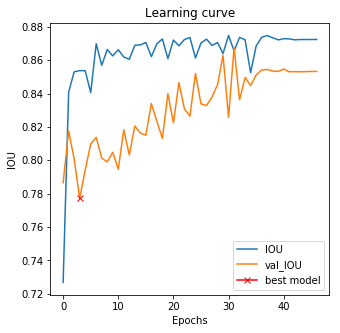

In [28]:
plt.figure(figsize=(5,5))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(5,5))
plt.title("Learning curve")
plt.plot(results.history["iou"], label="IOU")
plt.plot(results.history["val_iou"], label="val_IOU")
plt.plot( np.argmin(results.history["val_iou"]), np.min(results.history["val_iou"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("IOU")
plt.legend();

In [29]:
# load the best model
model.load_weights('model-seg_iou_3.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

90/90 [==============================] - 4s 49ms/step


[0.24015061457951864, 0.8541592836380005]

In [30]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

90/90 [==============================] - 5s 50ms/step


In [110]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 3, figsize=(10, 15))
    ax[0].imshow(X[ix])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze())
    ax[2].set_title(' Predicted')

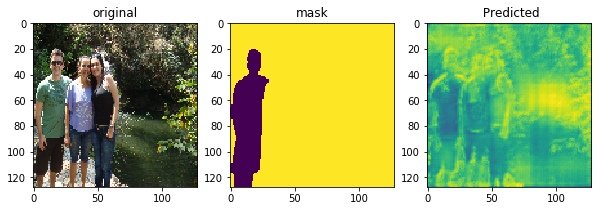

In [111]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=13)

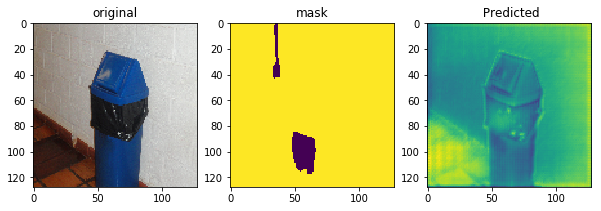

In [112]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=13)

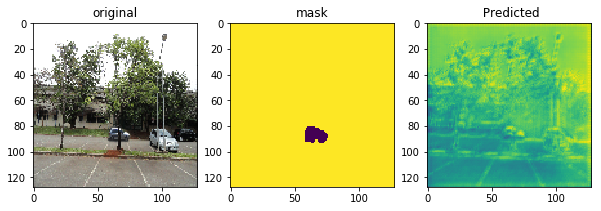

In [113]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=20)

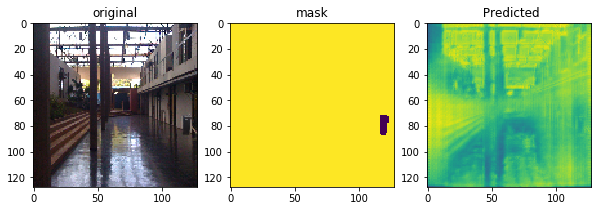

In [114]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=56)

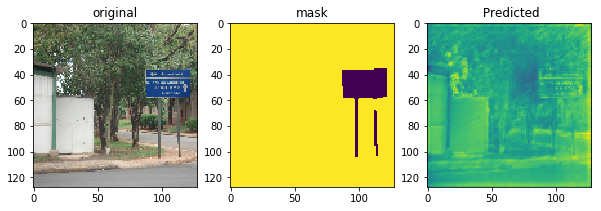

In [115]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=72)

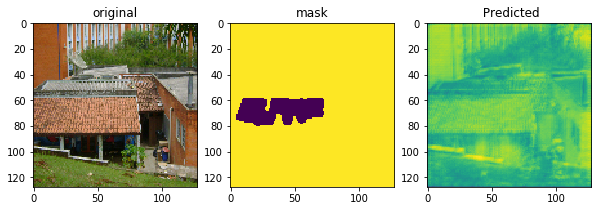

In [116]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=57)

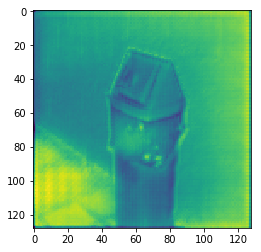

In [99]:
plt.imshow(preds_val[13].squeeze())

In [96]:
np.shape(preds_train[13].squeeze())

(128, 128)

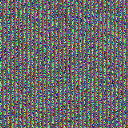

In [101]:
img = Image.fromarray(preds_train[13],'RGB')
img

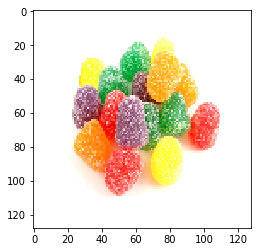

In [72]:
plt.imshow(X[12])

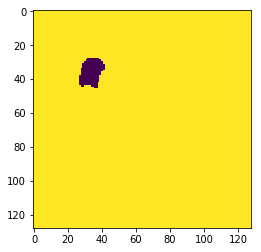

In [73]:
plt.imshow(y[12, ..., 0])

In [108]:
def plot_sample1(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze())

    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze())
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

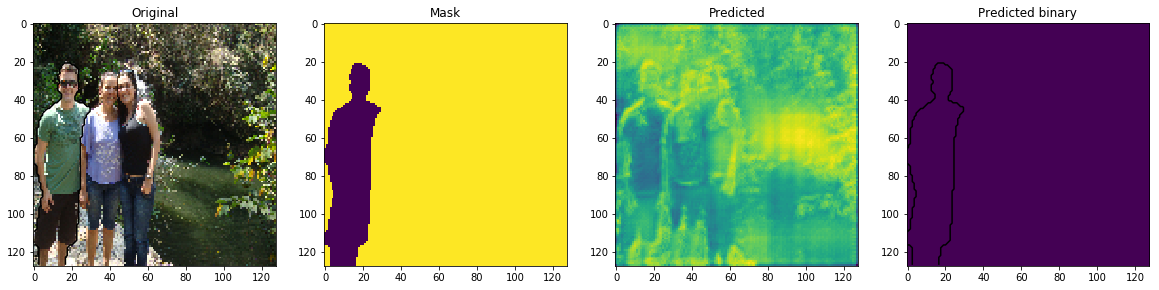

In [109]:
# Check if training data looks all right
plot_sample1(X_train, y_train, preds_train, preds_train_t, ix=13)

In [ ]:
plot_sample1(X_train, y_train, preds_train, preds_train_t, ix=13)